# Envelope Memory Usage without Fixed Dimensions

This experiment aims to evaluate the memory usage of the envelope seismic attribute operator without fixed dimensions.
On this notebook you will find:
- The problem statement
- The data collection for the experiment
- The evaluation of the experiment results.

## Problem Statement

Following [experiment 003](./003-envelope-memory-usage-with-one-fixed-dimension.ipynb), the goal for this experiment is to evaluate how the Envelope attribute behaves when keeping no dimension fixed.
During the experiment, we plan to:

1. Generate synthetic seismic data.
2. Apply the envelope operator to the synthetic data using the [DASF](https://github.com/discovery-unicamp/dasf-core) framework.
3. Assess the memory usage during this process using [TraceQ](https://github.com/discovery-unicamp/traceq).

## Data Collection

In this section, we will outline the steps needed to collect the necessary data for our experiment. The process is organized into the following steps:

1. **Setup Environment:**
  - Set up the environment with proper env variables and global constants to use during the experiment.

2. **Setup Dependencies:**
  - Set up the virtual environment running this notebook with the required dependencies.

3. **Setup the output directory:**
  - On this step we will setup the output directory in which we will save the experiment results.

4. **Generate Synthetic Seismic Data:**
  - Generate synthetic seismic data within a specified range of dimensions.

5. **Execute the Envelope Operator:**
  - Apply the envelope operator to the synthetic data using the prepared environment and tools.

After completing these steps, we will have the data generated by TraceQ to evaluate the memory usage of the envelope operator.

### Setup Environment

During the environment setup, we need to:
- Proper configure `PYTHONPATH`
- Setup dependencies

Below, we're configuring the `PYTHONPATH` to allow using the tools we've coded for the experiments

In [19]:
import os
import sys

seismic_path = os.path.abspath('../tools/seismic')
traceq_path = os.path.abspath('../tools/traceq')

if seismic_path not in sys.path:
    sys.path.append(seismic_path)

if traceq_path not in sys.path:
    sys.path.append(traceq_path)

print(sys.path)

['/home/delucca/.pyenv/versions/3.10.14/lib/python310.zip', '/home/delucca/.pyenv/versions/3.10.14/lib/python3.10', '/home/delucca/.pyenv/versions/3.10.14/lib/python3.10/lib-dynload', '', '/home/delucca/.pyenv/versions/3.10.14/envs/seismic-attributes-memory-profile/lib/python3.10/site-packages', '/home/delucca/src/unicamp/msc/seismic-attributes-memory-profile/tools/seismic', '/home/delucca/src/unicamp/msc/seismic-attributes-memory-profile/tools/traceq']


Now, lets setup some relevant global variables

In [20]:
from pprint import pprint

LOG_TRANSPORTS = ['CONSOLE', 'FILE']
LOG_LEVEL = 'DEBUG'

NUM_INLINES = 200
NUM_XLINES = 200
NUM_SAMPLES = 200
STEP_SIZE = 100
RANGE_SIZE = 15

print('Experiment config:')
pprint({
    'LOG_TRANSPORTS': LOG_TRANSPORTS,
    'LOG_LEVEL': LOG_LEVEL,
    'NUM_INLINES': NUM_INLINES,
    'NUM_XLINES': NUM_XLINES,
    'NUM_SAMPLES': NUM_SAMPLES,
    'STEP_SIZE': STEP_SIZE,
    'RANGE_SIZE': RANGE_SIZE
}, indent=2, sort_dicts=True)

Experiment config:
{ 'LOG_LEVEL': 'DEBUG',
  'LOG_TRANSPORTS': ['CONSOLE', 'FILE'],
  'NUM_INLINES': 200,
  'NUM_SAMPLES': 200,
  'NUM_XLINES': 200,
  'RANGE_SIZE': 15,
  'STEP_SIZE': 100}


### Setup Dependencies

Before running this step, make sure you are running this notebook in the environment defined by the `.python-version` file.

In [3]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


We need to install DASF tools to execute the experiment

In [4]:
%pip install git+https://github.com/discovery-unicamp/dasf-core.git

  Cloning https://github.com/discovery-unicamp/dasf-core.git to /tmp/pip-req-build-cjavqaw5
  Running command git clone --filter=blob:none --quiet https://github.com/discovery-unicamp/dasf-core.git /tmp/pip-req-build-cjavqaw5
  Resolved https://github.com/discovery-unicamp/dasf-core.git to commit c4841cdeb92f596b0c011fe0480897731556c2dd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/jcfaracco/xpysom-dask to /tmp/pip-install-fqmtg60k/xpysom-dask_238e2dfabcd144a88a6a2c39d2eddbad
  Running command git clone --filter=blob:none --quiet https://github.com/jcfaracco/xpysom-dask /tmp/pip-install-fqmtg60k/xpysom-dask_238e2dfabcd144a88a6a2c39d2eddbad
  Resolved https://github.com/jcfaracco/xpysom-dask to commit c21d10b09f68d89663e2e967bdb5781f76a96b13
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... d

Now, we need to install a package that is private.
In order to do this, you can either use the HTTPS or SSH protocol.

In the next cell you can install with the protocol you prefer, just uncomment the one you want to use.

In [5]:
%pip install git+ssh://git@github.com/discovery-unicamp/dasf-seismic.git ### Using SSH
# %pip install git+https://<token>@github.com/discovery-unicamp/dasf-seismic.git ### Using HTTPS -> Don't forget to replate <token> with your own PAT

%pip install torch

  Cloning ssh://****@github.com/discovery-unicamp/dasf-seismic.git to /tmp/pip-req-build-xgivfrsg
  Running command git clone --filter=blob:none --quiet 'ssh://****@github.com/discovery-unicamp/dasf-seismic.git' /tmp/pip-req-build-xgivfrsg
  Resolved ssh://****@github.com/discovery-unicamp/dasf-seismic.git to commit 8037f403f79dd2a628a6d0d14543ead670eb01d4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/discovery-unicamp/dasf-core.git (to revision main) to /tmp/pip-install-xrvz8a95/dasf_47d2a2ec2562406c9c445db2eb2302b7
  Running command git clone --filter=blob:none --quiet https://github.com/discovery-unicamp/dasf-core.git /tmp/pip-install-xrvz8a95/dasf_47d2a2ec2562406c9c445db2eb2302b7
  Resolved https://github.com/discovery-unicamp/dasf-core.git to commit c4841cdeb92f596b0c011fe0480897731556c2dd
  Installing build dependencies ... done
  Getting requirements to build whe

Now, we need to install the dependencies for the tools we use during the experiment.

In [6]:
%pip install -r ../tools/seismic/requirements.txt
%pip install -r ../tools/traceq/requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Setup output directory

In [7]:
import uuid
import os

from datetime import datetime

EXPERIMENT_ID = f'004-{datetime.now().strftime("%Y%m%d%H%M%S")}-{uuid.uuid4().hex[:6]}'
OUTPUT_DIR = f'../output/{EXPERIMENT_ID}'

os.makedirs(OUTPUT_DIR)

OUTPUT_DIR

'../output/004-20240910233507-5b49ab'

### Generate synthetic data

In [8]:
from seismic.data.synthetic import generate_varying_dimension

DATA_OUTPUT_DIR = f'{OUTPUT_DIR}/experiment'

synthetic_data_inline_paths = generate_varying_dimension(
    0,
    NUM_INLINES,
    NUM_XLINES,
    NUM_SAMPLES,
    STEP_SIZE,
    RANGE_SIZE,
    output_dir=DATA_OUTPUT_DIR,
)
synthetic_data_xline_paths = generate_varying_dimension(
    1,
    NUM_INLINES,
    NUM_XLINES,
    NUM_SAMPLES,
    STEP_SIZE,
    RANGE_SIZE,
    output_dir=DATA_OUTPUT_DIR,
)
synthetic_data_sample_paths = generate_varying_dimension(
    2,
    NUM_INLINES,
    NUM_XLINES,
    NUM_SAMPLES,
    STEP_SIZE,
    RANGE_SIZE,
    output_dir=DATA_OUTPUT_DIR,
)

synthetic_data_paths = synthetic_data_inline_paths + synthetic_data_xline_paths + synthetic_data_sample_paths

print(synthetic_data_paths)

2024-09-10 23:35:08.418 | INFO     | seismic.data.synthetic:generate_and_save_synthetic_data:130 - Generating synthetic data for shape (100, 200, 200)
2024-09-10 23:35:10.229 | INFO     | seismic.data.synthetic:generate_and_save_synthetic_data:130 - Generating synthetic data for shape (200, 200, 200)
2024-09-10 23:35:13.883 | INFO     | seismic.data.synthetic:generate_and_save_synthetic_data:130 - Generating synthetic data for shape (300, 200, 200)
2024-09-10 23:35:19.342 | INFO     | seismic.data.synthetic:generate_and_save_synthetic_data:130 - Generating synthetic data for shape (400, 200, 200)
2024-09-10 23:35:26.700 | INFO     | seismic.data.synthetic:generate_and_save_synthetic_data:130 - Generating synthetic data for shape (500, 200, 200)
2024-09-10 23:35:35.990 | INFO     | seismic.data.synthetic:generate_and_save_synthetic_data:130 - Generating synthetic data for shape (600, 200, 200)
2024-09-10 23:35:47.096 | INFO     | seismic.data.synthetic:generate_and_save_synthetic_data:1

### Execute the envelope attribute

On this step, we will execute the attribute for each generated synthetic data

In [ ]:
import traceq

from seismic.attributes import envelope

for synthetic_data_path in synthetic_data_paths:
    shape = synthetic_data_path.split('/')[-1].split('.')[0]
    traceq.load_config(
        {
            "output_dir": f'{OUTPUT_DIR}/profile-{shape}',
            "logger": {
                "enabled_transports": LOG_TRANSPORTS,
                "level": LOG_LEVEL,
            },
            "profiler": {
                "session_id": shape,
                "memory_usage": {
                    "enabled_backends": ['kernel'],
                },
            },
        }
    )

    traceq.profile(envelope.run, synthetic_data_path)

2024-09-10 23:52:47.448 | INFO     | traceq.profiler.main:run_profiler:15 - Starting profiler
2024-09-10 23:52:47.449 | DEBUG    | traceq.profiler.builders:build_trace_hooks:20 - Building trace hooks for enabled metrics: [<Metric.MEMORY_USAGE: 'MEMORY_USAGE'>, <Metric.TIME: 'TIME'>]
2024-09-10 23:52:47.450 | INFO     | traceq.profiler.metrics.memory_usage.builders:build_trace_hooks:12 - Enabled memory usage backends: "[<MemoryUsageBackend.KERNEL: 'KERNEL'>]"
2024-09-10 23:52:47.451 | DEBUG    | traceq.profiler.metrics.memory_usage.builders:build_trace_hooks:23 - Loading backend: "kernel"
2024-09-10 23:52:47.452 | DEBUG    | traceq.profiler.metrics.memory_usage.builders:build_trace_hooks:31 - Loaded backend: "<module 'traceq.profiler.metrics.memory_usage.backends.kernel' from '/home/delucca/src/unicamp/msc/seismic-attributes-memory-profile/tools/traceq/traceq/profiler/metrics/memory_usage/backends/kernel.py'>"
2024-09-10 23:52:47.453 | DEBUG    | traceq.profiler.metrics.memory_usage.bui

## Evaluating Experiment Results

In [22]:
import os
import gzip
import msgpack


def list_directories(path):
    entries = os.listdir(path)

    directories = [
        os.path.join(path, entry)
        for entry in entries
        if os.path.isdir(os.path.join(path, entry))
    ]
    return directories


def find_profiles(directory):
    parquet_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".prof"):
                full_path = os.path.join(root, file)
                parquet_files.append(full_path)
    return parquet_files


def get_session_paths(directory_path):
    dirs = list_directories(directory_path)
    shapes = [shape for shape in dirs if 'experiment' not in shape and 'checkpoints' not in shape]

    return [find_profiles(shape)[0] for shape in shapes]


def get_session_names(sessions):
    return [os.path.basename(session).split('/')[-1].split('.')[0] for session in sessions]


def normalize_metadata(sessions):
    for session in sessions:
        profile = load_profile(session)

        metadata = profile["metadata"]
        metadata_dict = {k: v for k, v in metadata.items()}

        entrypoint_segy_filepath = metadata_dict.pop("entrypoint_segy_filepath", None)
        if entrypoint_segy_filepath:
            entrypoint_shape = os.path.basename(entrypoint_segy_filepath).split(".")[0]
            entrypoint_shape = f"({entrypoint_shape.replace('-', ',')})"
            metadata_dict["entrypoint_shape"] = entrypoint_shape

        new_metadata = {k: v for k, v in metadata_dict.items()}
        profile["metadata"] = new_metadata

        with gzip.open(session, "wb") as f:
            packed = msgpack.packb(profile)
            f.write(packed)


session_paths = get_session_paths(OUTPUT_DIR)
normalize_metadata(session_paths)

session_names = get_session_names(session_paths)
zipped_sessions = list(zip(session_names, session_paths))

print(zipped_sessions)

[('200-1100-200', '../output/004-20240910233507-5b49ab/profile-200-1100-200/200-1100-200.prof'), ('200-200-1100', '../output/004-20240910233507-5b49ab/profile-200-200-1100/200-200-1100.prof'), ('200-900-200', '../output/004-20240910233507-5b49ab/profile-200-900-200/200-900-200.prof'), ('200-200-500', '../output/004-20240910233507-5b49ab/profile-200-200-500/200-200-500.prof'), ('200-200-1000', '../output/004-20240910233507-5b49ab/profile-200-200-1000/200-200-1000.prof'), ('200-200-300', '../output/004-20240910233507-5b49ab/profile-200-200-300/200-200-300.prof'), ('200-200-800', '../output/004-20240910233507-5b49ab/profile-200-200-800/200-200-800.prof'), ('100-200-200', '../output/004-20240910233507-5b49ab/profile-100-200-200/100-200-200.prof'), ('1400-200-200', '../output/004-20240910233507-5b49ab/profile-1400-200-200/1400-200-200.prof'), ('200-100-200', '../output/004-20240910233507-5b49ab/profile-200-100-200/200-100-200.prof'), ('200-500-200', '../output/004-20240910233507-5b49ab/prof

With the metadata normalized, and the organized data, we need now to get the peaks for each profile

In [24]:
from traceq.profiler.loaders import load_profile


def get_peak(profile_path):
    profile = load_profile(profile_path)
    data = profile['experiment']

    return max(item['kernel_memory_usage'] for item in data)


def get_unit(profile_path):
    profile = load_profile(profile_path)
    return profile['metadata']['kernel_memory_usage_unit']


peaks = [(shape, get_peak(profile_path), get_unit(profile_path)) for shape, profile_path in zipped_sessions]
print(peaks)

[('200-1100-200', 1892624.0, 'kb'), ('200-200-1100', 1896652.0, 'kb'), ('200-900-200', 1675012.0, 'kb'), ('200-200-500', 1244472.0, 'kb'), ('200-200-1000', 1791084.0, 'kb'), ('200-200-300', 1031276.0, 'kb'), ('200-200-800', 1573528.0, 'kb'), ('100-200-200', 813412.0, 'kb'), ('1400-200-200', 2229656.0, 'kb'), ('200-100-200', 806000.0, 'kb'), ('200-500-200', 1242416.0, 'kb'), ('200-800-200', 1569436.0, 'kb'), ('200-200-1400', 2231680.0, 'kb'), ('200-200-1200', 2006324.0, 'kb'), ('1000-200-200', 1797324.0, 'kb'), ('200-1000-200', 1784948.0, 'kb'), ('1500-200-200', 2343160.0, 'kb'), ('200-200-1500', 2340544.0, 'kb'), ('800-200-200', 1575872.0, 'kb'), ('400-200-200', 1134844.0, 'kb'), ('200-200-600', 1358268.0, 'kb'), ('1100-200-200', 1898708.0, 'kb'), ('200-600-200', 1358272.0, 'kb'), ('200-1500-200', 2340936.0, 'kb'), ('1200-200-200', 2008420.0, 'kb'), ('200-1200-200', 2008408.0, 'kb'), ('200-200-900', 1677312.0, 'kb'), ('300-200-200', 1029256.0, 'kb'), ('1300-200-200', 2113916.0, 'kb'), 

Now, we can create the graph

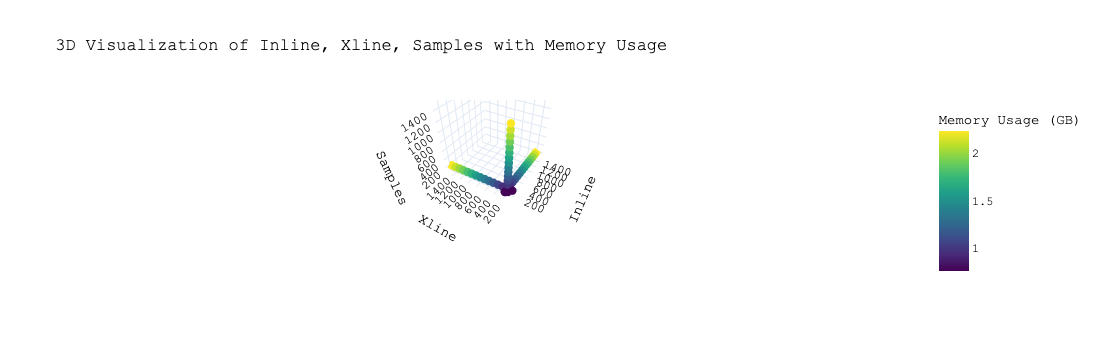

In [31]:
import plotly.graph_objects as go

inlines = [int(item[0].split('-')[0]) for item in peaks]
xlines = [int(item[0].split('-')[1]) for item in peaks]
samples = [int(item[0].split('-')[2]) for item in peaks]
memory_gb = [item[1] / 1048576 for item in peaks]  # Convert memory usage to GB

fig = go.Figure(data=[go.Scatter3d(
    x=inlines,
    y=xlines,
    z=samples,
    mode='markers',
    marker=dict(
        size=5,
        color=memory_gb,  # Set color based on memory usage
        colorscale='Viridis',  # Color scale to represent memory usage
        colorbar=dict(title="Memory Usage (GB)"),  # Add a color bar
        showscale=True,  # Show color scale for memory usage
    ),
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Inline',
        yaxis_title='Xline',
        zaxis_title='Samples',
        camera=dict(
            eye=dict(x=-2.5, y=-1.5, z=2),
            center=dict(x=0, y=0, z=-1)
        ),
    ),
    title="3D Visualization of Inline, Xline, Samples with Memory Usage",
    font=dict(family="Courier New, monospace", size=12, color="Black"),
    template="plotly_white"
)

fig.write_image(f'{OUTPUT_DIR}/memory-usage-3d.pdf', format="pdf", engine="kaleido", width=900, height=700)
fig.show()